In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import numpy as np
import os
import shutil
import  opennmt.inputters.record_inputter as inpu
import tensorflow as tf
import warnings
import time
import torch.utils.data as data
from torch import nn
from PIL import Image
import os
import os.path
import random

In [2]:
warnings.filterwarnings('ignore')

# Model Definition

In [4]:
class I(torch.nn.Module):
    def __init__(self):
        super(I, self).__init__()
        
    def forward(self, x):
        return x
    
    def extra_repr(self):
        return 'identity'


class MultiSignClf(torch.nn.Module):
    def __init__(self):
        super(MultiSignClf, self).__init__()
        self.model = torchvision.models.inception_v3(pretrained=True)
        self.model.fc = I()
        self.model.aux_logits = False
        self.fc_out = torch.nn.Linear(in_features=2048, out_features=61)
        self.fc_aux_out = torch.nn.Linear(in_features=2048, out_features=45)
        
    def forward(self, x):
        x = self.model(x)
        out = self.fc_out(x) 
        aux_out = self.fc_aux_out(x)
        return out, aux_out
    
    def get_feature(self,x):
        x = self.model(x)
        return x
    

# Image Dataset Class

In [5]:
class ImageFilelist(data.Dataset):
    def __init__(self, image_list, transform=None):
        self.imgs = image_list
        self.transform = transform

    def __getitem__(self, index):
        impath, target = self.imgs[index]
        img = self.img_loader(impath)
        if self.transform is not None:
            img = self.transform(img)
        return img, target

    def __len__(self):
        return len(self.imgs)
    
    def img_loader(self,path):
        return Image.open(path).convert('RGB')

# Visual Images

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(16,8))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Make Balanced Mini Batches

In [8]:
def make_weights_for_balanced_classes(images, nclasses,power=1,threshold=None, flag = 1):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1
    weight_per_class = np.zeros(nclasses)       
    N = float(sum(count))                                                   
    for i in range(flag,nclasses):
        if count[i] != 0:
            weight_per_class[i] = N/float(count[i])
    weight_per_class = np.array(weight_per_class)**power
    if threshold is not None:
        weight_per_class /= weight_per_class[weight_per_class!=0].min()
        weight_per_class = np.clip(weight_per_class,a_max=threshold,a_min=0)

    weight = [0] * len(images)
    if flag:
        weight_per_class[0] = 1
    print(weight_per_class)
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight 

# Load Images and  Add Color Jitter 

In [9]:
img_size = 302
trans_train = transforms.Compose([
    torchvision.transforms.RandomResizedCrop(img_size,scale=(0.8,1)),
    torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.Resize((img_size, img_size)),
    transforms.CenterCrop(img_size-3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

trans_test = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.CenterCrop(img_size-3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
batch_size = 32
test_batch_size= batch_size *4

# Load Danish and NZ Dataset

In [12]:
data_list = []
f = open('danish_nz_images.txt') 
count = 0
counts = [0] * 61
for l in f.readlines():
    path,label = l.split()
    my_path = path.split('/')
    video_name = my_path[-2]
    my_path = os.path.join(*my_path[-3:])
    label = int(float(label))
    data_list.append((my_path,label))
    counts[label] += 1
f.close()

# Test set of German Dataset

In [13]:
test_list = list()
f = open('3359-ph2014-MS-handshape-index.txt')
count = 0
for l in f.readlines():
    path,label = l.split()
    test_list.append((path,int(float(label))))
f.close()

# Split Train and Test

In [14]:
random.shuffle(data_list)
data_size = len(data_list)
dev_size = round(data_size * 0.05)
dev_list = data_list[:dev_size]
train_list = data_list[dev_size:]

# Data Loaders

In [17]:
train_data = ImageFilelist(image_list=train_list, transform=trans_train)
test_data = ImageFilelist(image_list=test_list, transform=trans_test)
dev_data = ImageFilelist(image_list=dev_list, transform=trans_test)

weights = make_weights_for_balanced_classes(train_list, 61,threshold=60,power=0.5)  
weights = torch.DoubleTensor(np.array(weights))
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)) 

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler = sampler,num_workers=8)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_batch_size,num_workers=8)
dev_loader = torch.utils.data.DataLoader(dev_data,batch_size=test_batch_size,num_workers=8)

[  1.           1.49095683   2.03664829   3.29126784   0.           3.97617515
   1.26828934   3.85780999   4.97554998   4.01386486   1.74639051
   1.32757627   3.0857051    1.03577279   2.37068662   6.74653208
  21.00724513   2.54425122  60.           8.3956007    1.43486011
  19.3888093    5.86572925   9.73960025   3.47610894   2.55650881
   7.86703527  58.16642789   3.3770541    3.92455404   6.05331308
   3.38658036  50.3736042    8.3956007    9.78543392   2.64757786   1.
   6.88693738   2.82592249   5.05635745   2.17378147   5.53756739
   1.88452502   3.365728     7.23322802   1.56768208   1.40251712
   2.95422224   9.92691741   2.16924172  10.50362256   3.21989474  60.
   6.95221787   4.2459886    1.58780124   2.9657198   60.          14.85436548
   0.          14.85436548]


# Turkish Dataset Load

In [18]:
aux_data_list = []
f = open('TurkishSign.txt')
count = 0
counts = [0] * 45
for i,l in enumerate(f.readlines()):
    domain = 1
    l = l.split()
    path, label = l[0],l[-1]
    my_path = path.split('\\')
    #my_path[0] ='TurkishSign'
    my_path = os.path.join(*my_path)
    label = int(float(label)) -1
    aux_data_list.append((my_path,label))
    counts[label] += 1
f.close()

In [19]:
random.shuffle(aux_data_list)
data_size = len(aux_data_list)
dev_size = round(data_size * 0.1)
aux_dev_list = aux_data_list[:dev_size]
aux_train_list = aux_data_list[dev_size:]

In [20]:
aux_train_data = ImageFilelist(image_list=aux_train_list, transform=trans_train)
aux_dev_data = ImageFilelist(image_list=aux_dev_list, transform=trans_test)

weights = make_weights_for_balanced_classes(aux_train_list, 45,threshold=60,flag=0)  
weights = torch.DoubleTensor(np.array(weights))
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)) 

aux_train_loader = torch.utils.data.DataLoader(aux_train_data, batch_size=batch_size, sampler = sampler,num_workers=8)
aux_dev_loader = torch.utils.data.DataLoader(aux_dev_data,batch_size=test_batch_size,num_workers=8)

[  1.10260664   1.07558946   1.           2.83892617   1.54379562
   2.28424153   3.46721311   3.2721519    5.10197368   2.42217595
   6.03501946   2.24782609   4.72865854   3.32832618   5.11881188
   3.37418419   9.21386139   5.95012788   3.66377953  16.15625     11.83969466
   2.06341463   9.87898089  13.33237822  21.84507042  11.43243243
   3.11863271  10.29424779   8.69719626  14.63207547  60.           8.53761468
  60.          36.06976744   9.87898089   6.22891566   6.3739726
   3.34027279   8.8125       5.10757409   6.56276446   6.48953975
   9.96359743  35.51908397  19.14814815]


# Set Device as GPU

In [22]:
device=torch.device("cuda:0")

# A batch Visual and Classes

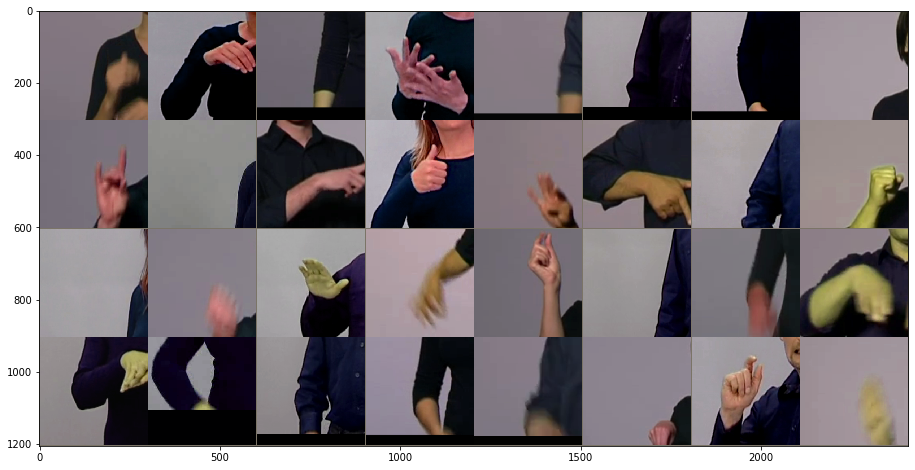

tensor([ 0, 33,  0,  6,  0,  0,  0,  0, 23,  0,  0,  1,  0,  2,  0, 45,  0,  0,
        13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 40, 24,  0])


In [27]:
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)
print(classes)

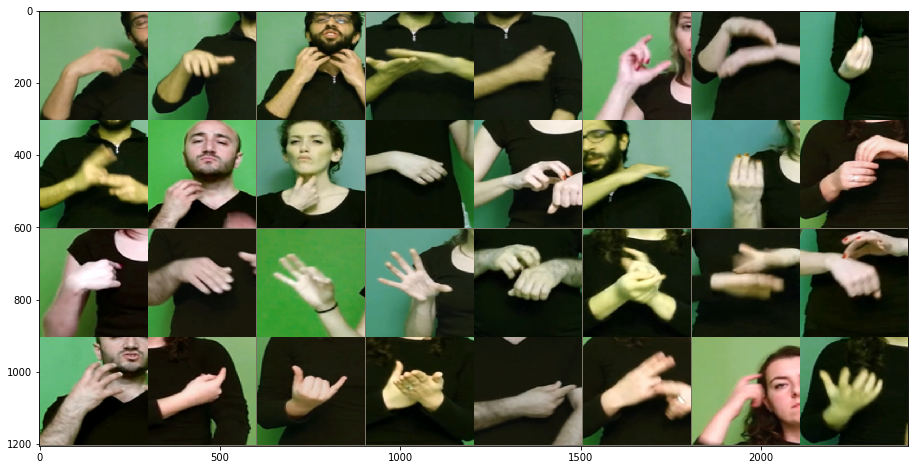

In [28]:
# Get a batch of training data
inputs, classes = next(iter(aux_train_loader))

# Make a grid from batch;
out = torchvision.utils.make_grid(inputs)

imshow(out)

# Set Model

In [29]:
model = MultiSignClf()
model.to(device)
model.train()
print('model created')

model created


In [30]:
iter_num = round(len(aux_train_data) / batch_size)

In [31]:
crit = torch.nn.CrossEntropyLoss()
lr = 1e-4
optimizer = torch.optim.Adam(lr=lr,params=model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=5,gamma=0.5)
alpha = 0.1 # Set a weight for TSL
my_step = 0
inner = 2
total_step = inner * total_epoch

NameError: name 'total_epoch' is not defined

In [ ]:
for epoch in range(1,40):
    model.train()
    epoch_loss = 0
    epoch_aux_loss = 0
    start = time.time()
    it = iter(train_loader)
    aux_it = iter(aux_train_loader)
    scheduler.step()
    #####################
    for i in range(iter_num):
        #######################
        optimizer.zero_grad()
        ########################
        x,y = it.next()
        logits,_  = model(x.to(device))
        loss = crit(logits,y.to(device))
        ########################
        aux_x, aux_y = aux_it.next()
        _, aux_logits = model(aux_x.to(device))
        aux_loss = crit(aux_logits,aux_y.to(device)) 
        ########################
        epoch_loss += loss.item() 
        epoch_aux_loss += aux_loss.item()
        ########################
        total_loss =  loss   +  aux_loss * alpha
        total_loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
        print(i,iter_num,epoch_loss/(i+1),epoch_aux_loss/(i+1),end='\r')
        if (i+1) % (iter_num//inner) == 0:
            print(i,iter_num,epoch_loss/(i+1),epoch_aux_loss/(i+1))
            model.eval()
            acc = 0
            for ti,(x,y) in enumerate(aux_dev_loader):
                with torch.no_grad():
                    _,logits = model(x.to(device))
                preds = logits.argmax(dim=1)
                print(ti/len(aux_dev_loader),end='\r')
                acc += (preds == y.to(device)).sum()
            acc = acc.cpu().detach().numpy()*100.0/len(aux_dev_data)
            print('Dev Accuracy:',acc,scheduler.get_lr())
            acc = 0
            for ti,(x,y) in enumerate(test_loader):
                with torch.no_grad():
                    logits,_ = model(x.to(device))
                preds = logits.argmax(dim=1)
                print(ti/len(test_loader),end='\r')
                acc += (preds == y.to(device)).sum()
            acc = acc.cpu().detach().numpy()*100.0/len(test_data)
            print('Test Accuracy:',acc,scheduler.get_lr())
            model_path = 'model' + str(my_step) + '.pth'
            torch.save(model,model_path)
            model.train()
            my_step += 1
            optimizer.step()

    print('----------------------'+str(epoch)+'------------------------')
    print('------------------------------------------------')
    print('Loss:',epoch_loss/iter_num,scheduler.get_lr()[0])
    print('Elasped Time:', round(time.time()-start))
    start = time.time()
    print('------------------------------------------------')